# 第6章 モデルの評価とハイパーパラメータのチューニングのベストプラクティス

* https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb
* モデルの性能の偏りのない推定量の算出
* 機械学習のアルゴリズムに共通する問題の診断
* 機械学習のモデルのチューニング
* さまざまな性能指標に基づく予測モデルの評価

## 6.1 パイプラインによるワークフローの効率化

### 6.1.1 Breast Cancer Wisconsin データセットを読み込む

* 悪性腫瘍細胞と良性腫瘍細胞の569のサンプル
* 最初の2つの列にはサンプルのIDと診断結果
* 診断結果Mは悪性(malignant)、Bは良性(benign)
* 3列目から32列目は細胞核のデジタル画像から算出された30個の実数値の特徴量

In [3]:
from IPython.core.display import display
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [4]:
# データセットを読み込む
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.shape

(569, 32)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
# 30この特徴量をNumPy配列のオブジェクトXに割り当てる
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
# M/Bを1/0にする
le = LabelEncoder()
y = le.fit_transform(y)

le.transform(['M', 'B'])

array([1, 0])

In [7]:
# トレーニングデータセットとテストデータセットに分割する
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
display(X_train.shape)
display(X_test.shape)

(455, 30)

(114, 30)

### 6.1.2 パイプラインで変換器と推定器を結合する

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# スケーリング(標準化)、主成分分析(PCA)、ロジスティック回帰をパイプラインで連結する
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))
                   ])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: {:.3f}'.format(pipe_lr.score(X_test, y_test)))

Test Accuracy: 0.947


## 6.2 k分割交差検証を使ったモデルの性能の評価

* ホールドアウト法(holdout method)
* k分割交差検証(k-fold corss-validation)

### 6.2.1 ホールドアウト法

* トレーニングデータセットをトレーニングデータセットと検証データセットに分割
* 検証データセットでの性能により、モデルを選択する

### 6.2.2 k分割交差検証

* 標準的に用いられるkの値は10
* 比較的小さなトレーニングデータセットの場合→分割数(k)を増やす
* 大きなデータセットの場合→分割数(k)を減らす
* かなり小さいデータセットの場合→サンプルの個数と同じにする(k=n)

* 改善したものに、層化k分割交差検証(stratified k-fold corss-validation)がある
* クラスの比率が均等でないときに、評価のバイアスとバリアンスが改善される

In [9]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

# 分割元データ、分割数、乱数生成器の状態を指定し、層化k分割交差検証のインスタンスを生成
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: {}, Class dist.: {}, Acc: {:.3f}'.format(k + 1, np.bincount(y_train[train]), score))

# 正解率の平均と標準偏差を出力
print('CV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


/Users/takanori/Private/python-machine-learning/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score
    
# 交差検証の cross_val_score 関数でモデルの正解率を算出
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: {}'.format(scores))
print('CV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


## 6.3 学習曲線と検証曲線によるアルゴリズムの診断

* 学習曲線(learning curve)
* 検証曲線(validation curve)

### 6.3.1 学習曲線を使ってバイアスとバリアンスの問題を診断する

array([ 40,  81, 122, 163, 204, 245, 286, 327, 368, 409])

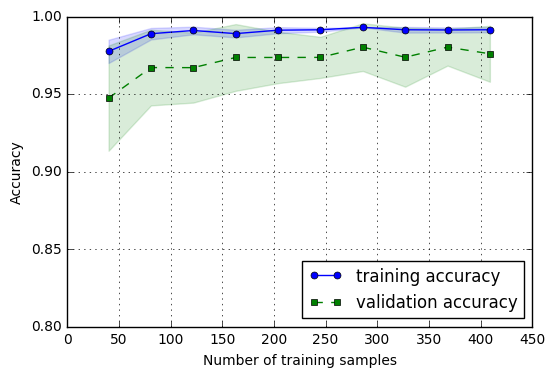

In [11]:
import matplotlib.pyplot as plt
if Version(sklearn_version) < '0.18':
    from sklearn.learning_curve import learning_curve
else:
    from sklearn.model_selection import learning_curve
    
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))
                   ])
# learning_curve 関数で交差検証による正解率を算出
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                         X=X_train, y=y_train,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         cv=10, n_jobs=1)
display(train_sizes)

# 平均と標準偏差を求める
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
# fill_between 関数で平均±標準偏差の幅を塗りつぶす
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

### 6.3.2 検証曲線を使って過学習と学習不足を明らかにする

* たとえばロジスティック回帰の逆正則化パラメータCを変化させる

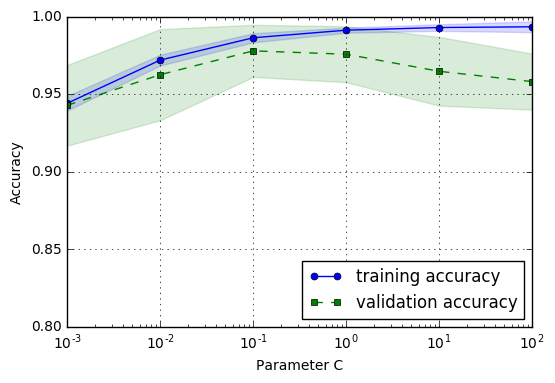

In [12]:
if Version(sklearn_version) < '0.18':
    from sklearn.learning_curve import validation_curve
else:
    from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# validation_curve関数によりモデルのパラメータを変化させ、交差検証による正解率を算出
# clf__C は LogisticRegression オブジェクトのパラメータ
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train, y=y_train,
                                             param_name='clf__C',
                                             param_range=param_range,
                                             cv=10)

# 平均と標準偏差を求める
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

## 6.4 グリッドサーチによる機械学習モデルのチューニング

* グリッドサーチ(grid search)
* ハイパーパラメーター(hyperparameter)
* 例: ロジスティック回帰の正則化パラメータ
* 例: 決定木の深さパラメータ

### 6.4.1 グリッドサーチを使ってハイパーパラメータをチューニングする

In [13]:
from sklearn.svm import SVC
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import GridSearchCV
else:
    from sklearn.model_selection import GridSearchCV

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))     
    ])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']},
              {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}
             ]
# ハイパーパラメータ値のリストparam_gridを指定し、グリッドサーチを行うGridSearchCVクラスのインスタンス化
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
# モデルの最良スコアを出力
print(gs.best_score_)
# 最良スコアとなるパラメータ値を出力
print(gs.best_params_)

0.978021978022
{'clf__kernel': 'linear', 'clf__C': 0.1}


In [14]:
# 選択されたモデルの性能を評価する
clf = gs.best_estimator_
display(clf)
clf.fit(X_train, y_train)
print('Test accuracy: {:.3f}'.format(clf.score(X_test, y_test)))

for params, mean_score, socres in gs.grid_scores_:
    print('{:.3f} (+/-{:.3f}) for {}'.format(mean_score, scores.std(), params))

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])

Test accuracy: 0.965
0.642 (+/-0.029) for {'clf__kernel': 'linear', 'clf__C': 0.0001}
0.938 (+/-0.029) for {'clf__kernel': 'linear', 'clf__C': 0.001}
0.960 (+/-0.029) for {'clf__kernel': 'linear', 'clf__C': 0.01}
0.978 (+/-0.029) for {'clf__kernel': 'linear', 'clf__C': 0.1}
0.976 (+/-0.029) for {'clf__kernel': 'linear', 'clf__C': 1.0}
0.971 (+/-0.029) for {'clf__kernel': 'linear', 'clf__C': 10.0}
0.952 (+/-0.029) for {'clf__kernel': 'linear', 'clf__C': 100.0}
0.945 (+/-0.029) for {'clf__kernel': 'linear', 'clf__C': 1000.0}
0.626 (+/-0.029) for {'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'clf__C': 0.0001}
0.626 (+/-0.029) for {'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'clf__C': 0.0001}
0.626 (+/-0.029) for {'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'clf__C': 0.0001}
0.626 (+/-0.029) for {'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'clf__C': 0.0001}
0.626 (+/-0.029) for {'clf__gamma': 1.0, 'clf__kernel': 'rbf', 'clf__C': 0.0001}
0.626 (+/-0.029) for {'clf__gamma': 10.0, 'clf__kernel': 'rb

/Users/takanori/Private/python-machine-learning/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### 6.4.2 入れ子式の交差検証によるアルゴリズムの選択

* 入れ子式の交差検証(nested corss-validation)

In [15]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: {:.3f} +/-{:.3f}'.format(np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/-0.025


In [17]:
from sklearn.tree import DecisionTreeClassifier
# ハイパーパラメーター値として決定木の深さパラメータを指定し、
# グリッドサーチを行う GridSearchCV クラスをインスタンス化
estimator = DecisionTreeClassifier(random_state=0)
param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}]
gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: {:.3f} +/-{:.3f}'.format(np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/-0.029


## 6.5 さまざまな性能評価指標

* 適合率(precision)
* 再現率(recall)
* F1 スコア(F1-score)

### 6.5.1 混同行列を解釈する

* 混同行列(cofusion matrix)
  * 真陽性(true positive)
  * 真陰性(true negative)
  * 偽陽性(false positive)
  * 偽陰性(false negative)

In [19]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
# テストと予測データから混同行列を生成
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


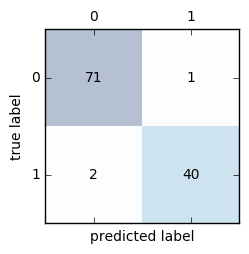

In [22]:
# 図のサイズを指定
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# matshow 関数で行列からヒートマップを描画
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### 6.5.2 分類モデルの適合率と再現率を最適化する

* 誤分類率(ERR)
* 正解率(ACC)
* 真陽性率(TPR)
* 偽陽性率(FPR)
* 適合率(PRE: precision)
* 再現率(REC: recall)

In [23]:
# 適合率、再現率、F1 スコアを出力
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('Precision: {:.3f}'.format(precision_score(y_true=y_test, y_pred=y_pred)))
print('Recall: {:.3f}'.format(recall_score(y_true=y_test, y_pred=y_pred)))
print('F1: {:.3f}'.format(f1_score(y_true=y_test, y_pred=y_pred)))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [26]:
# カスタムの性能指標を出力
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']},
              {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}
             ]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)
gs = gs.fit(X_train, y_train)
# モデルの最良スコアを出力
print(gs.best_score_)
# 最良スコアとなるパラメータ値を出力
print(gs.best_params_)

0.982798668208
{'clf__kernel': 'linear', 'clf__C': 0.1}


### 6.5.3 ROC曲線をプロットする

* 受信者操作特性(Receiver Operator Characteristic: ROC)曲線
* 曲線下面積(Area Under the Curve: AUC)

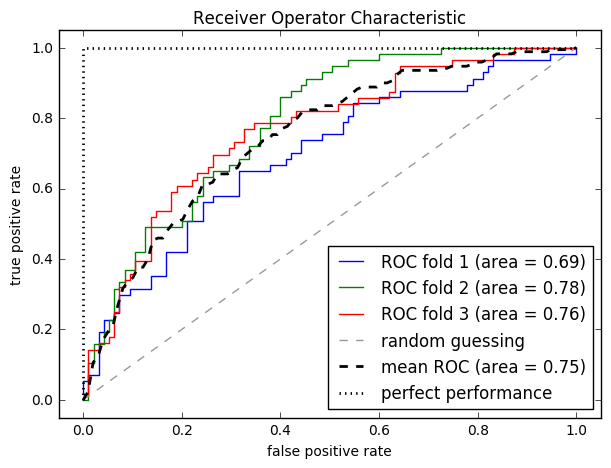

In [33]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
# スケーリング、主成分分析、ロジスティック回帰を指定して、Pipelineを作る
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))
                   ])
# 2つの特徴量を抽出
X_train2 = X_train[:, [4, 14]]
# 層化k分割交差検証イテレータを表す StratifiedKFold クラスをインスタンス化
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0

# 0から1までの間に100個の要素を生成
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    # predict_probaメソッドで確率を予測、fitメソッドでモデルに適合させる
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    # roc_curve関数でROC曲線の性能を計算してプロット
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    # FPR(X軸)とTPR(Y軸)を線形補完
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    # 曲線下面積(AUC)を計算
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold {:d} (area = {:.2f})'.format(i + 1, roc_auc))
    
# 当て推量をプロット
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

# FPR, TPR, ROC AUC それぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = {:.2f})'.format(mean_auc), lw=2)

# 完全に予測が正解したときのROC曲線をプロット
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

In [35]:
# 予測値のAUCと正解率を計算して出力
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=y_pred2)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_true=y_test, y_pred=y_pred2)))

ROC AUC: 0.662
Accuracy: 0.711


### 6.5.4 他クラス分類のための性能指標

* マクロ(macro)平均法
* マイクロ(micro)平均法
* 一対全(One-vs.-All)分類

In [39]:
from sklearn.metrics import precision_score, make_scorer
pre_scorer = make_scorer(score_func=precision_score,
                        pos_label=1,
                        greater_is_better=True,
                        average='micro')